In [1]:
%reload_ext dotenv
%dotenv

In [17]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset

from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

from sentence_transformers import SentenceTransformer

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

import pacmap
import numpy as np
import plotly.express as px

pd.set_option('display.max_colwidth', None)

In [3]:
ds = load_dataset("m-ric/huggingface_doc", split='train')

In [4]:
RAW_KB = [ LangchainDocument(page_content=doc['text'], metadata={'source': doc['source']}) for doc in tqdm(ds)]

  0%|          | 0/2647 [00:00<?, ?it/s]

#### Recursive Chunking

- Breakdown the text using a list of separators sorted from the most imp to least
- If first sep doesnt provide the right chunk size, go to next and so on

In [5]:
MARKDOWN_SEP = [
                "\n#{1,6} ",
                "```\n",
                "\n\\*\\*\\*+\n",
                "\n---+\n",
                "\n___+\n",
                "\n\n",
                "\n",
                " ",
                ""
            ]

text_splitter = RecursiveCharacterTextSplitter(
                    chunk_size=1000,
                    chunk_overlap=100,
                    add_start_index=True,
                    strip_whitespace=True,
                    separators=MARKDOWN_SEP

)

docs_processed=[]

for doc in RAW_KB:
    docs_processed += text_splitter.split_documents([doc])

In [6]:
print(f"Model's max seq len: {SentenceTransformer("thenlper/gte-small").max_seq_length}")

Model's max seq len: 512


Chunk size should be smaller than max seq len of the model otherwise chunk embeddings will lose relevance

  0%|          | 0/31085 [00:00<?, ?it/s]

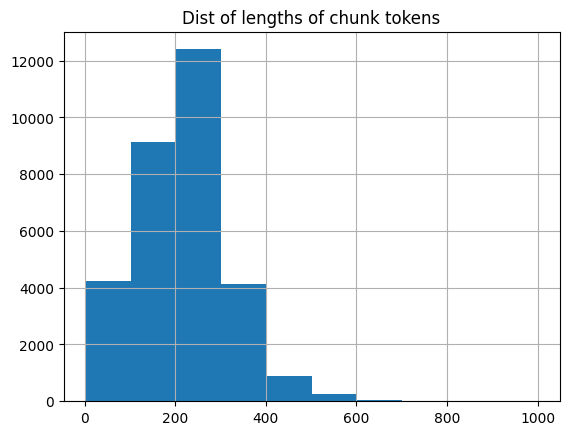

In [7]:
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")

lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

fig = pd.Series(lengths).hist()
plt.title("Dist of lengths of chunk tokens")
plt.show()

#### HuggingFace tokenizer text splitter

  0%|          | 0/17995 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Dist of lengths of chunk tokens')

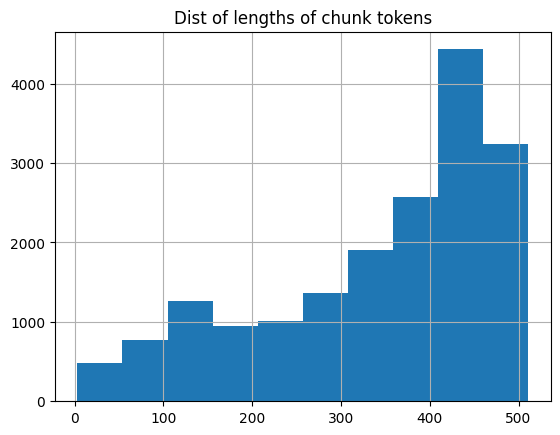

In [8]:
EMBED_MODEL_NAME = "thenlper/gte-small"

def split_documents(
                    chunk_size: int,
                    knowledge_base: List[LangchainDocument],
                    tokenizer_name: Optional[str] = EMBED_MODEL_NAME

) -> List[LangchainDocument]:
    
    """
        Split documents into chunks of max size 'chunk_size' tokens and return a list of documents    
    """
    
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
                        AutoTokenizer.from_pretrained(tokenizer_name),
                        chunk_size=512,
                        chunk_overlap=int(chunk_size/10),
                        add_start_index=True,
                        strip_whitespace=True,
                        separators=MARKDOWN_SEP,
    )

    docs_processed=[]

    for doc in knowledge_base:

        docs_processed += text_splitter.split_documents([doc])

    #remove duplicates
    unique_docs={}
    docs_processed_unique=[]
    for doc in docs_processed:
        if doc.page_content not in unique_docs:
            unique_docs[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(512,
                                 RAW_KB,
                                 tokenizer_name=EMBED_MODEL_NAME)



tokenizer = AutoTokenizer.from_pretrained(EMBED_MODEL_NAME)

lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

fig = pd.Series(lengths).hist()
plt.title("Dist of lengths of chunk tokens")


#### Embeddings

In [9]:
embeddings = HuggingFaceEmbeddings(
                                    model_name=EMBED_MODEL_NAME,
                                    multi_process=True,
                                    encode_kwargs={'normalize_embeddings': True}
)

KB_VDB = FAISS.from_documents(docs_processed, embeddings, distance_strategy=DistanceStrategy.COSINE)

KB_VDB

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [10]:
user_query = "How to avoid parallelism warning in huggingface tokenizers?"
query_vector = embeddings.embed_query(user_query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

#### Viz Embeddings

In [11]:
len(query_vector)

384

In [12]:
embed_proj = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [list(KB_VDB.index.reconstruct_n(idx, 1)[0]) 
                      for idx in range(len(docs_processed))] + [query_vector]

docs_proj = embed_proj.fit_transform(np.array(embeddings_2d), init="pca")



/Users/vivekr/Documents/vivek/projects/rag_lab/.viv-rag/lib/python3.12/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [13]:
df = pd.DataFrame.from_dict(
    [
        {
                'x': docs_proj[i, 0],
                'y': docs_proj[i, 1],
                'source': docs_processed[i].metadata['source'].split('/')[1],
                'extract': docs_processed[i].page_content[:100] + "...",
                'symbol': "circle",
                'size_col': 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": docs_proj[-1, 0],
            "y": docs_proj[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()


In [14]:
retreived_docs = KB_VDB.similarity_search(query=user_query, k=5)

print(retreived_docs[0].page_content)
print(retreived_docs[0].metadata)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

!-- DISABLE-FRONTMATTER-SECTIONS -->

# Tokenizers

Fast State-of-the-art tokenizers, optimized for both research and
production

[🤗 Tokenizers](https://github.com/huggingface/tokenizers) provides an
implementation of today's most used tokenizers, with a focus on
performance and versatility. These tokenizers are also used in [🤗 Transformers](https://github.com/huggingface/transformers).

# Main features:

- Train new vocabularies and tokenize, using today's most used tokenizers.
- Extremely fast (both training and tokenization), thanks to the Rust implementation. Takes less than 20 seconds to tokenize a GB of text on a server's CPU.
- Easy to use, but also extremely versatile.
- Designed for both research and production.
- Full alignment tracking. Even with destructive normalization, it's always possible to get the part of the original sentence that corresponds to any token.
- Does all the pre-processing: Truncation, Padding, add the special tokens your model needs.
{'source': 'hugging

#### LLM

In [19]:
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)

model = AutoModelForCausalLM.from_pretrained(
                READER_MODEL_NAME, quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
                model=model,
                tokenizer=tokenizer,
                task='text-generation',
                do_sample=True,
                temperature=0.2,
                repetition_penalty=1.1,
                return_full_text=False,
                max_new_tokens=500,
)



config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

RuntimeError: No GPU found. A GPU is needed for quantization.